# ANALYSIS TOP FILMS

In [57]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter, defaultdict
import community.community_louvain as community_louvain
import numpy as np

Create directed network.

Number of self-loops: 28
Number of nodes: 646
Number of edges: 3022


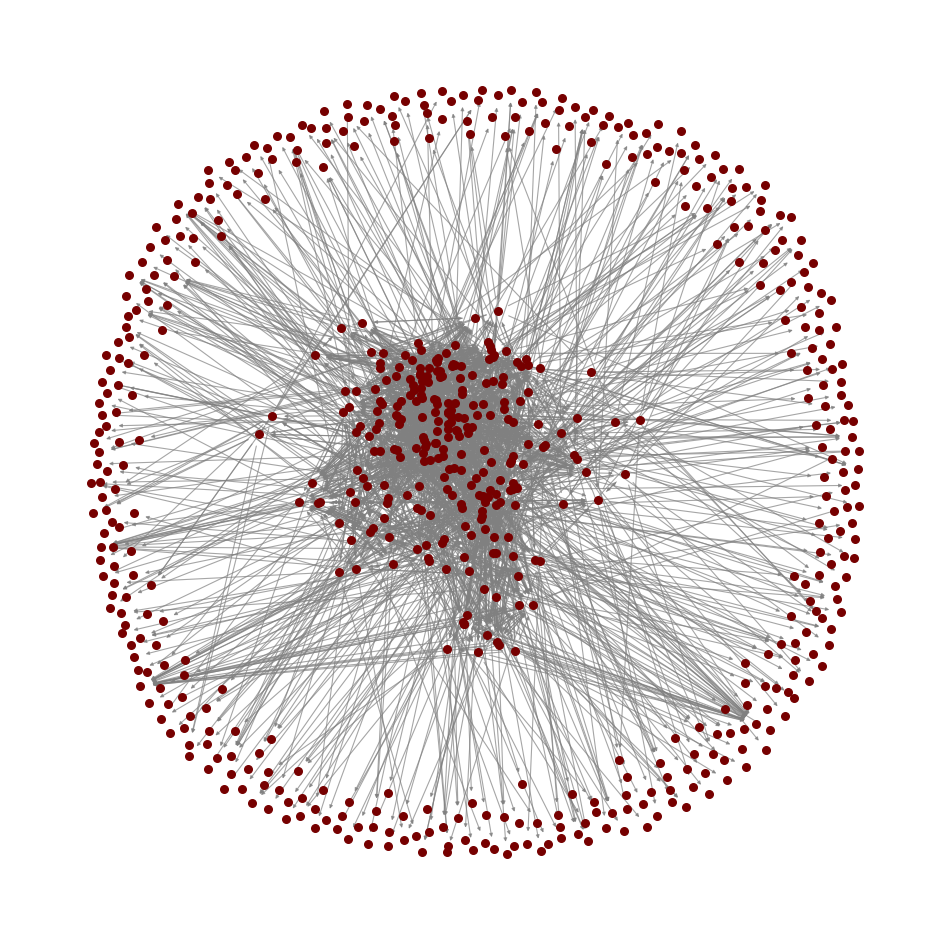

In [20]:
# Load the CSV file into a DataFrame
df = pd.read_csv('top_movie_data_with_similar.csv')

# Create an empty directed graph
D = nx.DiGraph()

# Add nodes and edges based on the similarity list
for index, row in df.iterrows():
    film = row['Name']
    similar_films = row['Similar Movies'].split(', ')  # Splitting the similar films into a list
    
    # Add the film as a node (it will be added automatically when creating edges)
    D.add_node(film)
    
    # Add edges between the film and its similar films
    for similar_film in similar_films:
        D.add_edge(film, similar_film)

# Delete self-loops
self_loops = list(nx.selfloop_edges(D))
print("Number of self-loops:", len(self_loops))
D.remove_edges_from(self_loops)

# Num of nodes and edges
print("Number of nodes:", D.number_of_nodes())
print("Number of edges:", D.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(D, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(D, pos, edge_color='gray', alpha=0.7, width=0.8, arrowsize=5)
nx.draw_networkx_nodes(D, pos, node_color='#760000', node_size=30)

# plt.title('Top Movies Directed', fontsize=15)
plt.axis('off')
plt.show()

Save all node names in a txt.

<div class="alert alert-warning">
DONT RUN AGAIN!
</div>

In [21]:
# Save node names to a text file
node_names = list(D.nodes)
with open('top_net_movies_titles.txt', 'w') as file:
    for node in node_names:
        file.write(f"{node}\n")

print(f"Node names have been saved.")

Node names have been saved.


Add metadata to each node as attribute.

In [22]:
# Folder containing the text files
metadata_folder = 'top_net_movies_info'

# Function to parse a metadata text file and exclude the "Synopsis" field
def parse_metadata(file_path):
    metadata = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        key = None
        for line in lines:
            line = line.strip()
            if line.endswith(':'):
                key = line[:-1]  # Remove the colon
                if key == 'Synopsis':  # Skip "Synopsis"
                    key = None
                else:
                    metadata[key] = ''
            elif key:  # Append the value to the current key
                metadata[key] += (' ' + line if metadata[key] else line)
    return metadata

# Add metadata to the nodes in the graph
for node in D.nodes():
    # First, assume the filename matches the node title directly
    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":" and "?" with "_"
    if not os.path.exists(metadata_file):
        if node == "Car Crash: Who's Lying?":
            sanitized_node = "Car Crash_ Who's Lying_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        metadata = parse_metadata(metadata_file)
        nx.set_node_attributes(D, {node: metadata})
    else:
        print(f"Metadata file not found for {node}")

In [23]:
# Check attributes of a specific node
sample_node = "Fight Club"
if sample_node in D.nodes:
    # Print the metadata of the node in one line each
    for key, value in D.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Fight Club 
Rating: 8.8 
Top 250 Rank: 13 
Duration: 139 
Release Date: 05 Nov 1999 (Denmark) 
Genres: Drama 
Director: David Fincher 
Actors: Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier, Richmond Arquette, David Andrews, George Maguire, Eugenie Bondurant, Christina Cabot, Helena Bonham Carter 
Languages: English 
Description: A nameless first-person narrator attends support groups in an attempt to subdue his emotional state and relieve his insomniac state. When he meets Marla, another fake attendee of support groups, his life seems to become a little more bearable. However, when he associates himself with Tyler he is dragged into an underground fight club and soap-making scheme. Together the two men spiral out of control and engage in competitive rivalry for love and power. 
Plot: ['An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more.', 'A nameless first-person narrator attends support groups in an attempt 

Calculate distributions.

Text(0, 0.5, 'Frequency')

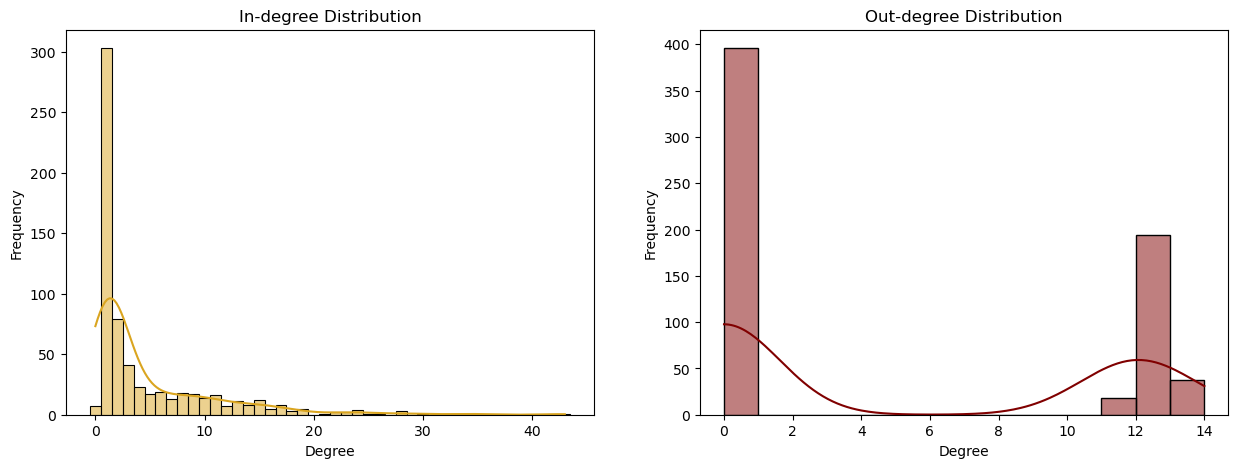

In [ ]:
# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in D.in_degree()]
out_degrees = [d for n, d in D.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

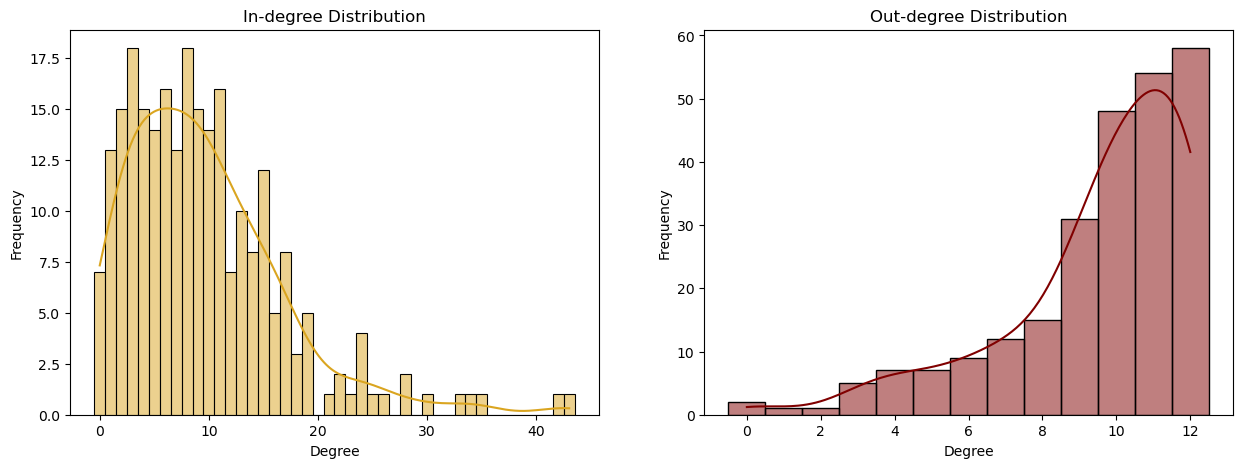

In [25]:
# Make a copy of the graph
H = D.copy()

# Remove the nodes with out-degree = 0
nodes_to_remove = [node for node, out_degree in dict(H.out_degree()).items() if out_degree == 0]
H.remove_nodes_from(nodes_to_remove)

# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in H.in_degree()]
out_degrees = [d for n, d in H.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Define bin range for out-degrees
binrange = (min(out_degrees) - 0.5, max(out_degrees) + 0.5)

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth, binrange=binrange)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Print top 5 in and out-degree movies.

In [27]:
# Top 5 nodes with highest in-degree with its genre and rating
in_degrees = dict(H.in_degree())
top_5_indegree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest in-degree:")
for node, indegree in top_5_indegree:
    print(f"{node} (In-degree: {indegree})")
    print(f"    Genres: {H.nodes[node].get('Genres')}")
    print(f"    Rating: {H.nodes[node].get('Rating')}")

Top 5 nodes with highest in-degree:
Forrest Gump (In-degree: 43)
    Genres: Drama, Romance 
    Rating: 8.8 
Fight Club (In-degree: 42)
    Genres: Drama 
    Rating: 8.8 
Pulp Fiction (In-degree: 35)
    Genres: Crime, Drama 
    Rating: 8.9 
Inception (In-degree: 34)
    Genres: Action, Adventure, Sci-Fi, Thriller 
    Rating: 8.8 
Se7en (In-degree: 33)
    Genres: Crime, Drama, Mystery, Thriller 
    Rating: 8.6 


In [ ]:
# Top 5 nodes with highest out-degree with its genre and rating
out_degrees = dict(H.out_degree())
top_5_outdegree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest out-degree:")
for node, outdegree in top_5_outdegree:
    print(f"{node} (Out-degree: {outdegree})")
    print(f"    Genres: {H.nodes[node].get('Genres')}")
    print(f"    Rating: {H.nodes[node].get('Rating')}")

Top 5 nodes with highest out-degree:
The Shawshank Redemption (Out-degree: 12)
    Genres: Drama 
    Rating: 9.3 
The Dark Knight (Out-degree: 12)
    Genres: Action, Crime, Drama, Thriller 
    Rating: 9.0 
Forrest Gump (Out-degree: 12)
    Genres: Drama, Romance 
    Rating: 8.8 
Fight Club (Out-degree: 12)
    Genres: Drama 
    Rating: 8.8 
Pulp Fiction (Out-degree: 12)
    Genres: Crime, Drama 
    Rating: 8.9 


Make undirected network.

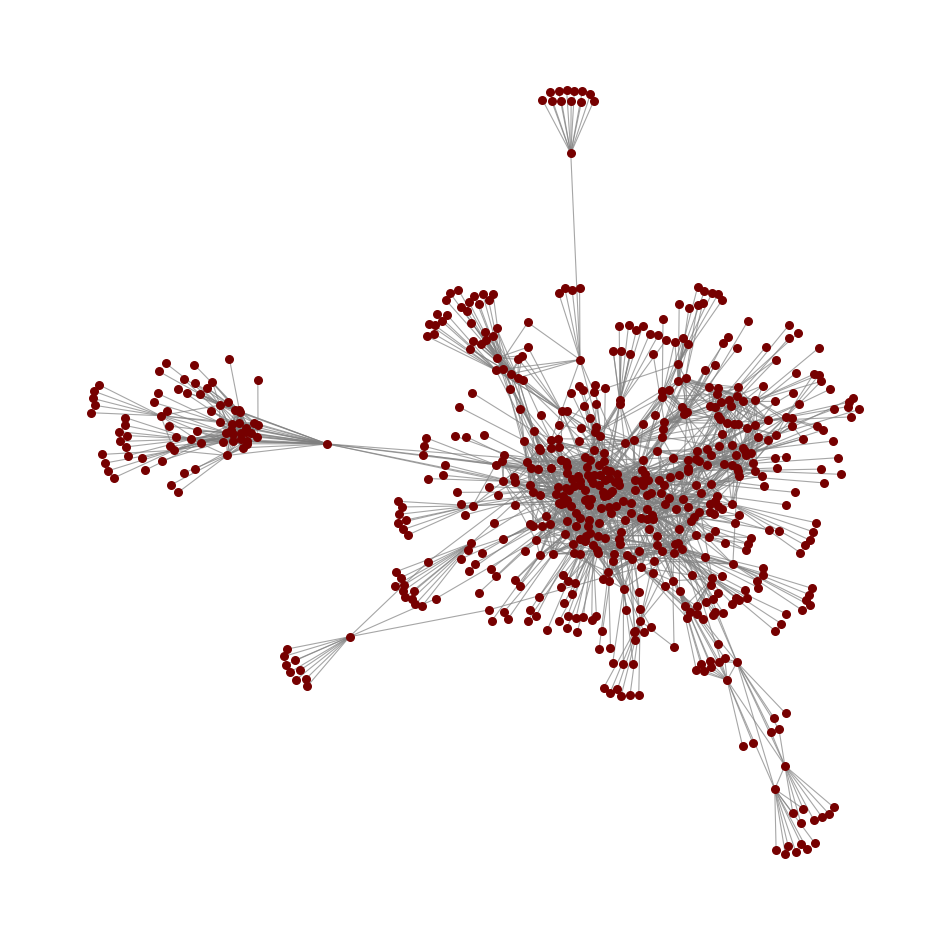

In [29]:
# Make undirected graph
G = D.to_undirected()

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(G, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color='#760000', node_size=30)

# plt.title('Top Movies Undirected', fontsize=15)
plt.axis('off')
plt.show()

In [30]:
# Check if the undirected graph has still attributes
sample_node = "Fight Club"
if sample_node in D.nodes:
    # Print the metadata of the node in one line each
    for key, value in D.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Fight Club 
Rating: 8.8 
Top 250 Rank: 13 
Duration: 139 
Release Date: 05 Nov 1999 (Denmark) 
Genres: Drama 
Director: David Fincher 
Actors: Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier, Richmond Arquette, David Andrews, George Maguire, Eugenie Bondurant, Christina Cabot, Helena Bonham Carter 
Languages: English 
Description: A nameless first-person narrator attends support groups in an attempt to subdue his emotional state and relieve his insomniac state. When he meets Marla, another fake attendee of support groups, his life seems to become a little more bearable. However, when he associates himself with Tyler he is dragged into an underground fight club and soap-making scheme. Together the two men spiral out of control and engage in competitive rivalry for love and power. 
Plot: ['An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more.', 'A nameless first-person narrator attends support groups in an attempt 

Make communities:
- Genre partition

In [31]:
# Create a dictionary to hold the partition
genre_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in G.nodes(data=True):
    # Get the 'Genres' attribute and split it into a list, if present
    genres = data.get("Genres", "")  # Default to an empty string if 'Genres' is missing
    genres_list = [g.strip() for g in genres.split(",")] if genres else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_genre = genres_list[0] if genres_list else None
    
    # Add node to the appropriate community in the partition
    if first_genre not in genre_partition:
        genre_partition[first_genre] = []
    genre_partition[first_genre].append(node)

print("Total number of genres:", len(genre_partition), "\n")
for genre, nodes in genre_partition.items():
    print(f"{genre}: {len(nodes)} nodes")

Total number of genres: 19 

Drama: 152 nodes
Action: 143 nodes
Crime: 68 nodes
Biography: 35 nodes
Short: 20 nodes
Adventure: 38 nodes
Comedy: 63 nodes
Music: 1 nodes
None: 2 nodes
Animation: 72 nodes
Documentary: 26 nodes
Mystery: 5 nodes
Horror: 14 nodes
News: 1 nodes
Film-Noir: 2 nodes
Fantasy: 1 nodes
Family: 1 nodes
Thriller: 1 nodes
Sport: 1 nodes


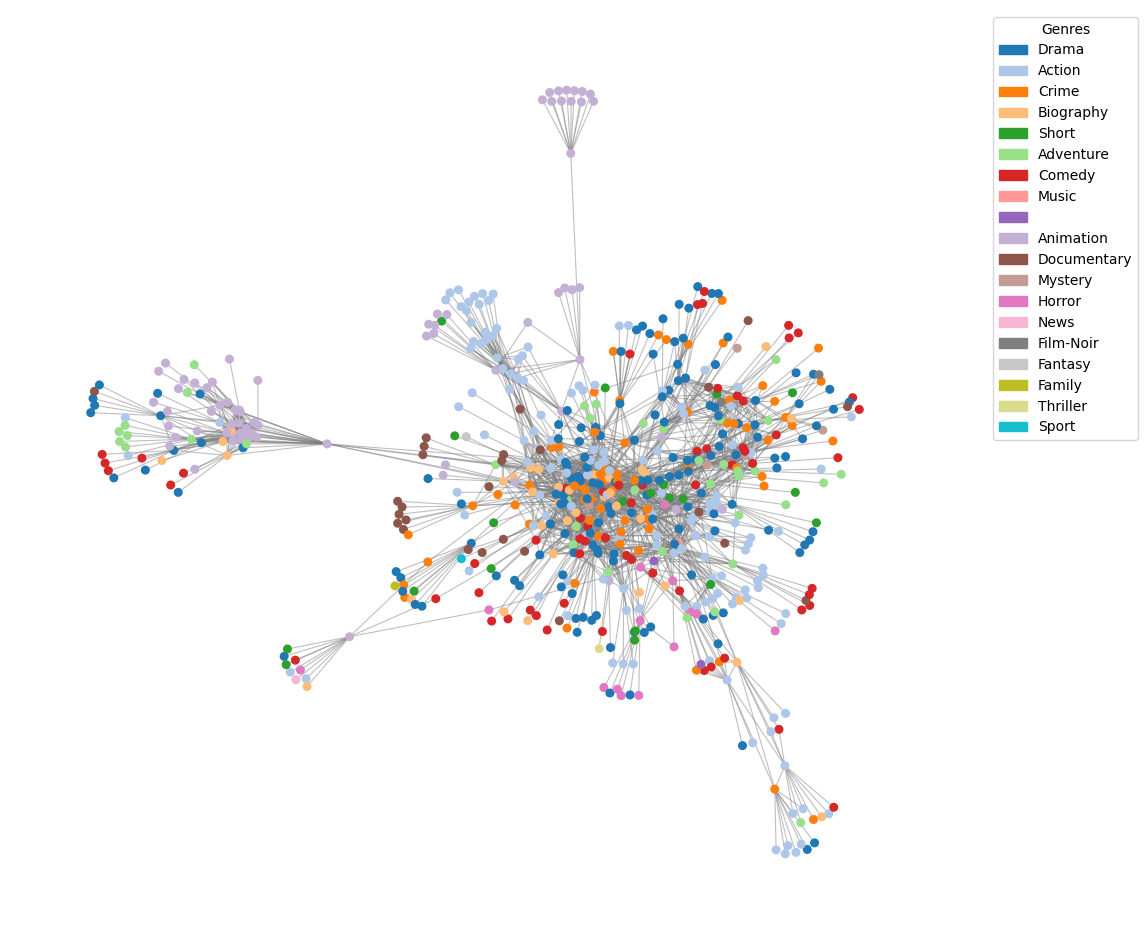

In [ ]:
# Create a color map for each genre
genre_to_color = {genre: plt.cm.tab20.colors[i % 20] for i, genre in enumerate(genre_partition.keys())}

# Create a list to store the color of each node based on its genre
node_colors = []
for node in G.nodes:
    # Find the genre of the current node by checking the partition_genre dictionary
    for genre, nodes in genre_partition.items():
        if node in nodes:
            node_colors.append(genre_to_color[genre])  # Assign the corresponding genre color
            break

# Plot the graph with colors based on genre
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# Add a title
#plt.title("Genre Communities in Top Movies", fontsize=15)

# Create legend
legend_handles = [mpatches.Patch(color=color, label=genre) for genre, color in genre_to_color.items()]
plt.legend(handles=legend_handles, title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('off')
plt.show()

Calculate the modularity of the genre-based partition.

In [36]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in genre_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the genre-based partition (formula book):", modularity_genre)

Modularity of the genre-based partition (formula book): 0.32332278506770135


In [37]:
# Modularity using NetworkX
modularity_genre2 = nx.algorithms.community.modularity(G, [set(nodes) for nodes in genre_partition.values()])
print("Modularity of the genre-based partition (networkX formula):", modularity_genre2)

Modularity of the genre-based partition (networkX formula): 0.19655630558902218


- Director partition

In [39]:
# Create a dictionary to hold the partition
director_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in G.nodes(data=True):
    # Get the 'Directors' attribute and split it into a list, if present
    directors = data.get("Director", "")  # Default to an empty string if 'Genres' is missing
    directors_list = [g.strip() for g in directors.split(",")] if directors else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_director = directors_list[0] if directors_list else None
    
    # Add node to the appropriate community in the partition
    if first_director not in director_partition:
        director_partition[first_director] = []
    director_partition[first_director].append(node)

print("Total number of directors:", len(director_partition), "\n")
for director, nodes in director_partition.items():
    print(f"{director}: {len(nodes)} nodes")

Total number of directors: 309 

Frank Darabont: 2 nodes
Christopher Nolan: 9 nodes
Francis Ford Coppola: 5 nodes
Robert Zemeckis: 4 nodes
David Fincher: 4 nodes
Quentin Tarantino: 8 nodes
Steven Spielberg: 10 nodes
Peter Jackson: 6 nodes
Sidney Lumet: 3 nodes
Martin Scorsese: 9 nodes
Jonathan Demme: 1 nodes
Lana Wachowski: 2 nodes
Todd Phillips: 2 nodes
None: 59 nodes
Cal Evans: 2 nodes
Roman Polanski: 3 nodes
Irvin Kershner: 1 nodes
Milos Forman: 2 nodes
Meg Pfeiffer: 1 nodes
Vidhu Vinod Chopra: 1 nodes
Rajkumar Hirani: 4 nodes
Nithilan Saminathan: 1 nodes
Nitesh Tiwari: 2 nodes
Kiran Rao: 1 nodes
Sandeep Reddy Vanga: 1 nodes
T.J. Gnanavel: 1 nodes
Nadine Labaki: 1 nodes
Nag Ashwin: 1 nodes
Nishikant Kamat: 1 nodes
Bahareh Ahmadi: 1 nodes
Liza Williams: 1 nodes
Pete Docter: 4 nodes
Roberto Benigni: 1 nodes
Richard Marquand: 1 nodes
George Lucas: 3 nodes
J.J. Abrams: 2 nodes
Rian Johnson: 1 nodes
Sudha Kongara: 1 nodes
Lokesh Kanagaraj: 2 nodes
Vetrimaaran: 1 nodes
Hanu Raghavapudi: 1

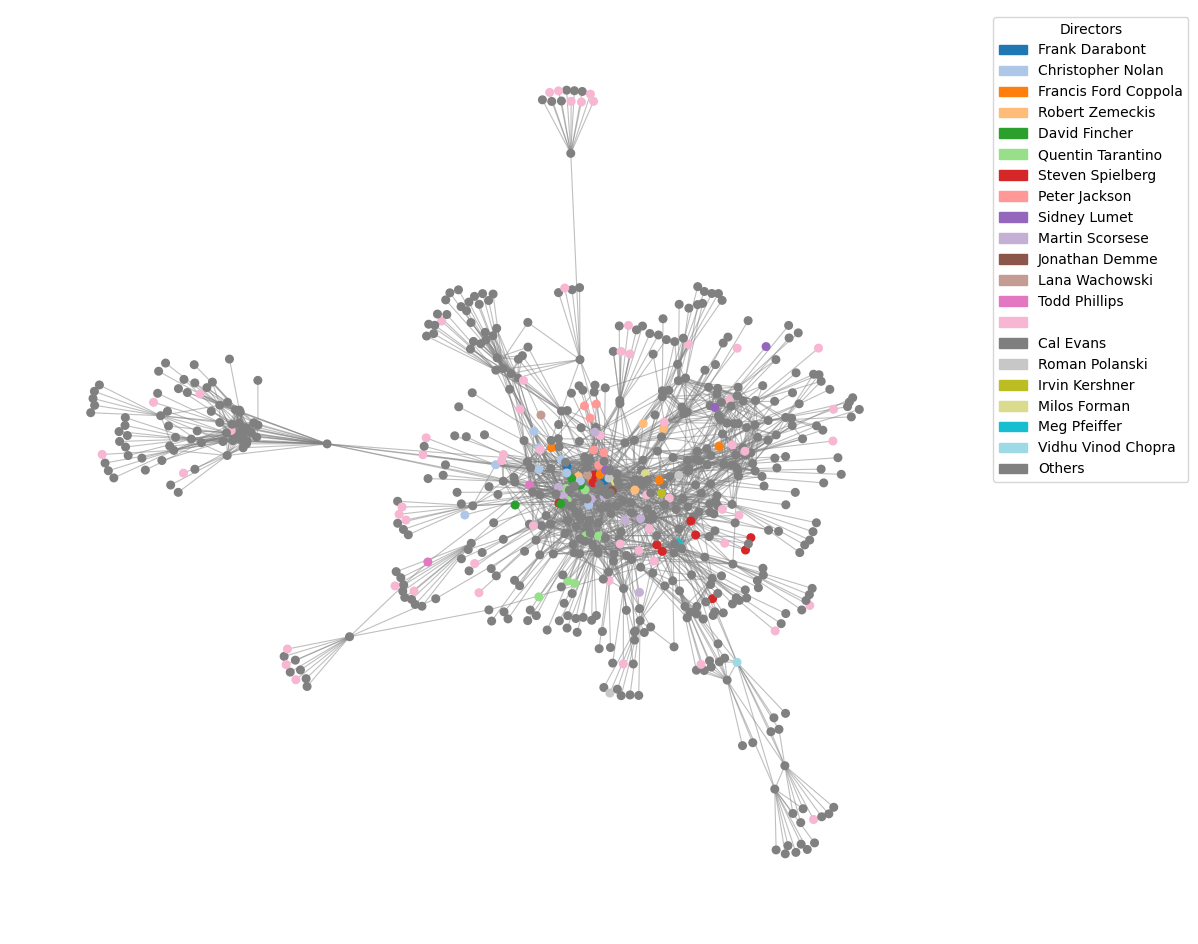

In [43]:
# Create a color map for each director (top 20)
director_to_color = {director: plt.cm.tab20.colors[i % 20] for i, director in enumerate(list(director_partition.keys())[:20])}

# Create a list to store the color of each node based on its director
node_colors = []
for node in G.nodes:
    # Find the director of the current node by checking the partition_director dictionary
    for director, nodes in director_partition.items():
        if node in nodes:
            node_colors.append(director_to_color.get(director, 'gray'))  # Assign the corresponding director color
            break

# Plot the graph with colors based on director
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent

# Draw the edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# Add a title
#plt.title("Top 20 Director Communities in Top Movies", fontsize=15)

# Create a legend for top 10 directors and gray for others
legend_handles = [mpatches.Patch(color=color, label=director) for director, color in director_to_color.items()]
legend_handles.append(mpatches.Patch(color='gray', label='Others'))
plt.legend(handles=legend_handles, title="Directors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove axis
plt.axis('off')

# Display the plot
plt.show()

Calculate modularity of the director based communities.

In [44]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_director = 0
for community in director_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_director += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the director-based partition (formula book):", modularity_director)

Modularity of the director-based partition (formula book): 0.1321586330306703


In [45]:
# Modularity using NetworkX
modularity_director2 = nx.algorithms.community.modularity(G, [set(nodes) for nodes in director_partition.values()])
print("Modularity of the director-based partition (networkX formula):", modularity_director2)

Modularity of the director-based partition (networkX formula): 0.12056134229494309


- Louvain partition

In [47]:
# Compute the Louvain partition
louvain_partition = community_louvain.best_partition(G)

# Group nodes by their assigned community
community_groups = defaultdict(list)
for node, community in louvain_partition.items():
    community_groups[community].append(node)

print("Number of communities:", len(community_groups), "\n")
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

Number of communities: 10 

Community 0: 85 nodes
Community 1: 77 nodes
Community 2: 77 nodes
Community 3: 32 nodes
Community 4: 73 nodes
Community 9: 54 nodes
Community 6: 126 nodes
Community 7: 13 nodes
Community 8: 97 nodes
Community 5: 12 nodes


C:\Users\Alba\AppData\Local\Temp\ipykernel_22500\3809391496.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors


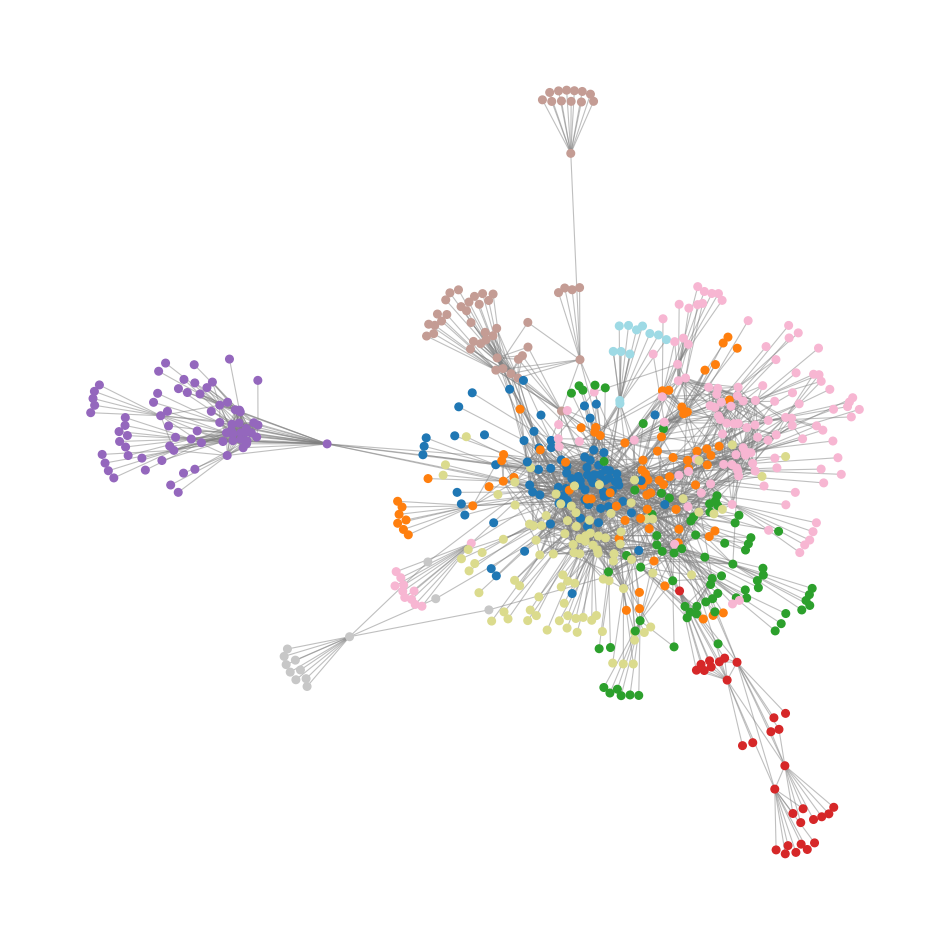

In [48]:

# Assign a unique color to each community
num_communities = len(community_groups)
color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors
community_to_color = {community: color_palette(i) for i, community in enumerate(community_groups.keys())}

# Create a list of colors for each node based on its community
node_colors = [community_to_color[louvain_partition[node]] for node in G.nodes]

# Plot the graph with nodes colored by community
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# # Add a title
# plt.title("Communities in Top Movies (Louvain Method)", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()

Calculate modularity of luvain communities.

In [49]:
# Calculate modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(louvain_partition, G)
print("Modularity of Louvain partition:", modularity_louvain)

Modularity of Louvain partition: 0.6337333396370088


Calculate confussion matrix of genre partition vs louvain partition.

In [ ]:
# Modify the nodes info to get it as list instead of string
G2 = nx.Graph(G)

# Modify the nodes to have lists of genres and directors
for node in G2.nodes:
    # Get the current node data
    data = G2.nodes[node]
    
    # Get the genres and directors as strings
    genres = data.get("Genres", "")
    directors = data.get("Director", "")
    actors = data.get("Actors", "")
    producers = data.get("Producer", "")
    production_companies = data.get("Production Companies", "")
    
    # Split the strings into lists
    genres_list = [g.strip() for g in genres.split(",")] if genres else []
    directors_list = [d.strip() for d in directors.split(",")] if directors else []
    actors_list = [a.strip() for a in actors.split(",")] if actors else []
    producers_list = [p.strip() for p in producers.split(",")] if producers else []
    production_companies_list = [pc.strip() for pc in production_companies.split(",")] if production_companies else []

    # Update the node data with the lists
    data["Genres"] = genres_list
    data["Director"] = directors_list
    data["Actors"] = actors_list
    data["Producer"] = producers_list
    data["Production Companies"] = production_companies_list

# Check the updated node data for a sample node
sample_node = "A Beautiful Mind"
if sample_node in G2.nodes:
    # Print the metadata of the node in one line each
    for key, value in G2.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: A Beautiful Mind 
Rating: 8.2 
Top 250 Rank: 150 
Duration: 135 
Release Date: 01 Mar 2002 (Denmark) 
Genres: ['Biography', 'Drama', 'Mystery']
Director: ['Ron Howard']
Actors: ['Russell Crowe', 'Ed Harris', 'Jennifer Connelly', 'Christopher Plummer', 'Paul Bettany', 'Adam Goldberg', 'Josh Lucas', 'Anthony Rapp', 'Jason Gray-Stanford', 'Judd Hirsch']
Languages: English 
Description: From the heights of notoriety to the depths of depravity, John Forbes Nash, Jr. experienced it all. A mathematical genius, he made an astonishing discovery early in his career and stood on the brink of international acclaim. But the handsome and arrogant Nash soon found himself on a painful and harrowing journey of self-discovery. After many years of struggle, he eventually triumphed over his tragedy, and finally - late in life - received the Nobel Prize. 
Plot: ['A mathematical genius, John Nash made an astonishing discovery early in his career and stood on the brink of international acclaim. But th

In [ ]:
# Get the 10 most common genres
most_common_genres = sorted(genre_partition.keys(), key=lambda g: len(genre_partition[g]), reverse=True)[:10]

# Get 10 biggest communities
community_count = pd.Series(louvain_partition).value_counts()
most_common_communities = community_count.nlargest(10).index.tolist()

# Confusion matrix
D_matrix = np.zeros((len(most_common_genres), len(most_common_communities)), dtype=int)

for node in G2.nodes():
    # Get the genres directly from the node attributes
    node_genres = G2.nodes[node]['Genres']  # List of genres for the node
    node_community = louvain_partition[node]  # Community ID for the node
    
    # Check if the community is one of the largest ones
    if node_community in most_common_communities:
        community_index = most_common_communities.index(node_community)
        
        # Count all genres of this node
        for genre in node_genres:
            if genre in most_common_genres:
                genre_index = most_common_genres.index(genre)
                D_matrix[genre_index, community_index] += 1  # Increment the count in the matrix

# Display the confusion matrix
D_df = pd.DataFrame(D_matrix, index=most_common_genres, columns=most_common_communities)
print("Confusion Matrix (Genres vs Communities):")
print(D_df)


Confusion Matrix (Genres vs Communities):
              6   8   0   1   2   4   9   3  7   5
Drama        97  73  67  58  10  33  11  27  3  11
Action        6  14  25  12  43  11  43  15  2   2
Animation     0   5   0   3   0  38  27   0  1   0
Crime        24  32  24  24   0   2   2  12  1   5
Comedy       23  26   6   7  12  33   8   9  3   1
Adventure    14   4  15   3  42  45  35   4  2   0
Biography     8  11   8  12   1   6   1   3  1   0
Documentary   3   5   4  11   2   1   0   0  0   0
Short         5   6   4   4   4   0   1   0  2   0
Horror        4   4   3   0  19   2   0   1  5   5
